In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [2]:
df=pd.read_csv('../../data/learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [3]:
class DNN_4(nn.Module):
    def __init__(self, input_dim,hidden_units1,hidden_units2,hidden_units3,hidden_units4,dropout1,dropout2,dropout3,dropout4):
        super(DNN_4, self).__init__()
        self.layer1 = nn.Linear(input_dim,hidden_units1)
        self.layer2 = nn.Linear(hidden_units1,hidden_units2)
        self.layer3 = nn.Linear(hidden_units2, hidden_units3)
        self.layer4 = nn.Linear(hidden_units3, hidden_units4)
        self.output_layer = nn.Linear(hidden_units4, 1)

        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)
        self.dropout3 = nn.Dropout(dropout3)
        self.dropout4 = nn.Dropout(dropout4)


        self.bn1 = nn.BatchNorm1d(hidden_units1)
        self.bn2 = nn.BatchNorm1d(hidden_units2)
        self.bn3 = nn.BatchNorm1d(hidden_units3)
        self.bn4 = nn.BatchNorm1d(hidden_units4)

        
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = self.dropout1(x)
        
        x = torch.relu(self.bn2(self.layer2(x)))
        x = self.dropout2(x)

        x = torch.relu(self.bn3(self.layer3(x)))
        x = self.dropout3(x)

        x = torch.relu(self.bn4(self.layer4(x)))
        x = self.dropout4(x)

        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [4]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

Optunaの設定

In [ ]:
def objective(trial):
    hidden_units1 = trial.suggest_int("hidden_units1", 216, 512, step=2)
    hidden_units2 = trial.suggest_int("hidden_units2", 128, 216, step=2)
    hidden_units3 = trial.suggest_int("hidden_units3", 64, 128, step=2)
    hidden_units4 = trial.suggest_int("hidden_units4", 4, 64, step=2)
    dropout1 = trial.suggest_float("dropout1", 0.1, 0.5, step=0.05)
    dropout2 = trial.suggest_float("dropout2", 0.1, 0.5, step=0.05)
    dropout3 = trial.suggest_float("dropout3", 0.1, 0.5, step=0.05)
    dropout4 = trial.suggest_float("dropout4", 0.1, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
    weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
    

    model = DNN_4(input_dim=X_train_tensor.shape[1], hidden_units1=hidden_units1,hidden_units2=hidden_units2,hidden_units3=hidden_units3,hidden_units4=hidden_units4, dropout1=dropout1,dropout2=dropout2,dropout3=dropout3,dropout4=dropout4).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adagrad(model.parameters(),lr=learning_rate,weight_decay=weight_decay)

    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    
    model.eval()
    val_true, val_pred, val_prob = [], [], []
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            val_outputs = model(X_val).squeeze()
            predictions = (val_outputs >= 0.5).float()
            val_true.extend(y_val.cpu().numpy())
            val_pred.extend(predictions.cpu().numpy())
            val_prob.extend(val_outputs.cpu().numpy())


    accuracy = accuracy_score(val_true, val_pred)
    precision = precision_score(val_true, val_pred)
    recall = recall_score(val_true, val_pred)
    f1 = f1_score(val_true, val_pred)
    mcc = matthews_corrcoef(val_true, val_pred)
    specificity = recall_score(val_true, val_pred, pos_label=0)

    # ログ
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    return precision


In [6]:
# 使用可能なGPUの数を取得
num_gpus = torch.cuda.device_count()

if num_gpus == 0:
    print("使用可能なGPUはありません。")
else:
    print(f"使用可能なGPUの数: {num_gpus}")
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  メモリ使用状況: {torch.cuda.memory_allocated(i) / 1024**2:.2f} MB / {torch.cuda.get_device_properties(i).total_memory / 1024**2:.2f} MB")
        print(f"  CUDA対応バージョン: {torch.cuda.get_device_properties(i).major}.{torch.cuda.get_device_properties(i).minor}")


使用可能なGPUの数: 2
GPU 0: NVIDIA GeForce GTX 1080 Ti
  メモリ使用状況: 0.00 MB / 11169.31 MB
  CUDA対応バージョン: 6.1
GPU 1: NVIDIA GeForce GTX 1080 Ti
  メモリ使用状況: 0.00 MB / 11172.19 MB
  CUDA対応バージョン: 6.1


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)


print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)


[I 2024-11-28 19:02:49,119] A new study created in memory with name: no-name-90947ed1-bf29-4446-88d7-f8bf973a4b08
/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 19:04:31,230] Trial 1 finished with value: 0.5328467153284672 and parameters: {'hidden_units1': 406, 'hidden_units2': 182, 'hidden_units3': 114, 'hidden_units4': 64, 'dropout1': 0.15000000000000002, 'dropout2': 0.25, 'dropout3': 0.1, 'dropout4': 0.1, 'learning_rate': 0.003694910109088444, 'weight_decay': 1.0220170812197191e-05}. Best is trial 1 with value: 0.5328467153284672.


Accuracy: 63.53%
Precision: 0.4932
Recall: 0.5794
F1 Score: 0.5328
Matthews Correlation Coefficient: 0.2390
Specificity: 0.6667


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:05:21,518] Trial 2 finishe

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 19:06:11,433] Trial 3 finished with value: 0.3671497584541063 and parameters: {'hidden_units1': 468, 'hidden_units2': 186, 'hidden_units3': 68, 'hidden_units4': 4, 'dropout1': 0.1, 'dropout2': 0.1, 'dropout3': 0.4, 'dropout4': 0.30000000000000004, 'learning_rate': 0.0010159147253489627, 'weight_decay': 0.000834866478362976}. Best is trial 1 with value: 0.5328467153284672.


Accuracy: 62.68%
Precision: 0.4691
Recall: 0.3016
F1 Score: 0.3671
Matthews Correlation Coefficient: 0.1258
Specificity: 0.8089


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:07:00,523] Trial 4 finished with value: 0.5578635014836796 and parameters: {'hidden_units1': 460, 'hidden_units2': 148, 'hidden_units3': 66, 'hidden_units4': 62, 'dropout1': 0.25, 'dropout2': 0.15000000000000002, 'dropout3': 0.4, 'dropout4': 0.15000000000000002, 'learning_rate': 1.4531395871559963e-05, 'weight_decay': 2.9646745416057107e-05}. Best is trial

Accuracy: 57.55%
Precision: 0.4455
Recall: 0.7460
F1 Score: 0.5579
Matthews Correlation Coefficient: 0.2214
Specificity: 0.4800


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:07:49,690] Trial 5 finished with value: 0.35406698564593303 and parameters: {'hidden_units1': 438, 'hidden_units2': 140, 'hidden_units3': 118, 'hidden_units4': 4, 'dropout1': 0.35, 'dropout2': 0.35, 'dropout3': 0.1, 'dropout4': 0.1, 'learning_rate': 0.003584573558379515, 'weight_decay': 0.027879394469454546}. Best is trial 4 with value: 0.5578635014836796.

Accuracy: 61.54%
Precision: 0.4458
Recall: 0.2937
F1 Score: 0.3541
Matthews Correlation Coefficient: 0.1007
Specificity: 0.7956


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:08:39,400] Trial 6 finished with value: 0.39316239316239315 and parameters: {'hidden_units1': 324, 'hidden_units2': 200, 'hidden_units3': 72, 'hidden_units4': 6, 'dropout1': 0.1, 'dropout2': 0.5, 'dropout3': 0.5, 'dropout4': 0.15000000000000002, 'learning_rate': 0.023657714707463747, 'weight_decay': 1.3243546577398252e-05}. Best is trial 4 with value: 0.55

Accuracy: 59.54%
Precision: 0.4259
Recall: 0.3651
F1 Score: 0.3932
Matthews Correlation Coefficient: 0.0930
Specificity: 0.7244


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:09:28,027] Trial 7 finished with value: 0.4050632911392405 and parameters: {'hidden_units1': 348, 'hidden_units2': 180, 'hidden_units3': 78, 'hidden_units4': 44, 'dropout1': 0.35, 'dropout2': 0.5, 'dropout3': 0.1, 'dropout4': 0.2, 'learning_rate': 0.07067412444770986, 'weight_decay': 3.0576778269147716e-05}. Best is trial 4 with value: 0.5578635014836796.


Accuracy: 59.83%
Precision: 0.4324
Recall: 0.3810
F1 Score: 0.4051
Matthews Correlation Coefficient: 0.1041
Specificity: 0.7200


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
/home/gonken/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-11-28 19:10:17,195] Trial 8 finishe

Accuracy: 64.10%
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Matthews Correlation Coefficient: 0.0000
Specificity: 1.0000


[I 2024-11-28 19:11:05,696] Trial 9 finished with value: 0.43478260869565216 and parameters: {'hidden_units1': 306, 'hidden_units2': 140, 'hidden_units3': 90, 'hidden_units4': 28, 'dropout1': 0.45000000000000007, 'dropout2': 0.45000000000000007, 'dropout3': 0.35, 'dropout4': 0.35, 'learning_rate': 0.06931945156255238, 'weight_decay': 5.1127749278503446e-05}. Best is trial 4 with value: 0.5578635014836796.


Accuracy: 62.96%
Precision: 0.4808
Recall: 0.3968
F1 Score: 0.4348
Matthews Correlation Coefficient: 0.1648
Specificity: 0.7600


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:11:55,029] Trial 10 finished with value: 0.3448275862068966 and parameters: {'hidden_units1': 508, 'hidden_units2': 162, 'hidden_units3': 92, 'hidden_units4': 50, 'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'dropout3': 0.25, 'dropout4': 0.5, 'learning_rate': 1.035460335137642e-05, 'weight_decay': 0.0003444008998524861}. Best is trial 4 with value: 0.

Accuracy: 67.52%
Precision: 0.6250
Recall: 0.2381
F1 Score: 0.3448
Matthews Correlation Coefficient: 0.2207
Specificity: 0.9200


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:12:45,961] Trial 11 finished with value: 0.48028673835125446 and parameters: {'hidden_units1': 404, 'hidden_units2': 166, 'hidden_units3': 112, 'hidden_units4': 64, 'dropout1': 0.2, 'dropout2': 0.25, 'dropout3': 0.25, 'dropout4': 0.1, 'learning_rate': 2.2920994250448133e-05, 'weight_decay': 0.00016448710593063026}. Best is trial 4 with value: 0.55786350148

Accuracy: 58.69%
Precision: 0.4379
Recall: 0.5317
F1 Score: 0.4803
Matthews Correlation Coefficient: 0.1446
Specificity: 0.6178


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:13:36,079] Trial 12 finished with value: 0.6091644204851752 and parameters: {'hidden_units1': 426, 'hidden_units2': 158, 'hidden_units3': 106, 'hidden_units4': 54, 'dropout1': 0.15000000000000002, 'dropout2': 0.2, 'dropout3': 0.2, 'dropout4': 0.25, 'learning_rate': 0.00015351054811403274, 'weight_decay': 1.2027169916911559e-05}. Best is trial 12 with value

Accuracy: 58.69%
Precision: 0.4612
Recall: 0.8968
F1 Score: 0.6092
Matthews Correlation Coefficient: 0.3241
Specificity: 0.4133


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:14:25,532] Trial 13 finished with value: 0.555205047318612 and parameters: {'hidden_units1': 480, 'hidden_units2': 160, 'hidden_units3': 102, 'hidden_units4': 54, 'dropout1': 0.25, 'dropout2': 0.15000000000000002, 'dropout3': 0.2, 'dropout4': 0.25, 'learning_rate': 8.500764998498477e-05, 'weight_decay': 0.00010497488348984609}. Best is trial 12 with value:

Accuracy: 59.83%
Precision: 0.4607
Recall: 0.6984
F1 Score: 0.5552
Matthews Correlation Coefficient: 0.2318
Specificity: 0.5422


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:15:14,915] Trial 14 finished with value: 0.5764705882352941 and parameters: {'hidden_units1': 438, 'hidden_units2': 152, 'hidden_units3': 86, 'hidden_units4': 30, 'dropout1': 0.2, 'dropout2': 0.2, 'dropout3': 0.2, 'dropout4': 0.35, 'learning_rate': 0.00011574362593684696, 'weight_decay': 0.008901013870268296}. Best is trial 12 with value: 0.609164420485175

Accuracy: 58.97%
Precision: 0.4579
Recall: 0.7778
F1 Score: 0.5765
Matthews Correlation Coefficient: 0.2579
Specificity: 0.4844


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:16:04,576] Trial 15 finished with value: 0.5615141955835962 and parameters: {'hidden_units1': 410, 'hidden_units2': 150, 'hidden_units3': 86, 'hidden_units4': 28, 'dropout1': 0.15000000000000002, 'dropout2': 0.30000000000000004, 'dropout3': 0.25, 'dropout4': 0.45000000000000007, 'learning_rate': 0.00014119671499385994, 'weight_decay': 0.011492821701153115}

Accuracy: 60.40%
Precision: 0.4660
Recall: 0.7063
F1 Score: 0.5615
Matthews Correlation Coefficient: 0.2437
Specificity: 0.5467


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:16:55,241] Trial 16 finished with value: 0.5 and parameters: {'hidden_units1': 428, 'hidden_units2': 128, 'hidden_units3': 104, 'hidden_units4': 18, 'dropout1': 0.15000000000000002, 'dropout2': 0.25, 'dropout3': 0.2, 'dropout4': 0.35, 'learning_rate': 0.00016909633784575062, 'weight_decay': 0.005385592842492293}. Best is trial 12 with value: 0.609164420485

Accuracy: 60.68%
Precision: 0.4600
Recall: 0.5476
F1 Score: 0.5000
Matthews Correlation Coefficient: 0.1819
Specificity: 0.6400


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:17:44,662] Trial 17 finished with value: 0.5174825174825175 and parameters: {'hidden_units1': 378, 'hidden_units2': 154, 'hidden_units3': 84, 'hidden_units4': 36, 'dropout1': 0.2, 'dropout2': 0.2, 'dropout3': 0.2, 'dropout4': 0.4, 'learning_rate': 0.00044035755514081304, 'weight_decay': 0.07538475602653687}. Best is trial 12 with value: 0.6091644204851752.

Accuracy: 60.68%
Precision: 0.4625
Recall: 0.5873
F1 Score: 0.5175
Matthews Correlation Coefficient: 0.1975
Specificity: 0.6178


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:18:33,815] Trial 18 finished with value: 0.35121951219512193 and parameters: {'hidden_units1': 506, 'hidden_units2': 172, 'hidden_units3': 96, 'hidden_units4': 34, 'dropout1': 0.35, 'dropout2': 0.30000000000000004, 'dropout3': 0.15000000000000002, 'dropout4': 0.30000000000000004, 'learning_rate': 6.553189846379648e-05, 'weight_decay': 0.001287475325944897}

Accuracy: 62.11%
Precision: 0.4557
Recall: 0.2857
F1 Score: 0.3512
Matthews Correlation Coefficient: 0.1087
Specificity: 0.8089


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:19:24,311] Trial 19 finished with value: 0.41025641025641024 and parameters: {'hidden_units1': 274, 'hidden_units2': 216, 'hidden_units3': 106, 'hidden_units4': 18, 'dropout1': 0.1, 'dropout2': 0.2, 'dropout3': 0.30000000000000004, 'dropout4': 0.25, 'learning_rate': 0.0005071621156542933, 'weight_decay': 0.7775636840201404}. Best is trial 12 with value: 0.

Accuracy: 60.68%
Precision: 0.4444
Recall: 0.3810
F1 Score: 0.4103
Matthews Correlation Coefficient: 0.1188
Specificity: 0.7333


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:20:12,760] Trial 20 finished with value: 0.48484848484848486 and parameters: {'hidden_units1': 444, 'hidden_units2': 172, 'hidden_units3': 80, 'hidden_units4': 40, 'dropout1': 0.30000000000000004, 'dropout2': 0.15000000000000002, 'dropout3': 0.15000000000000002, 'dropout4': 0.4, 'learning_rate': 3.706128678394087e-05, 'weight_decay': 0.009215931773298339}.

Accuracy: 61.25%
Precision: 0.4638
Recall: 0.5079
F1 Score: 0.4848
Matthews Correlation Coefficient: 0.1758
Specificity: 0.6711


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:21:02,009] Trial 21 finished with value: 0.5263157894736842 and parameters: {'hidden_units1': 404, 'hidden_units2': 156, 'hidden_units3': 86, 'hidden_units4': 22, 'dropout1': 0.15000000000000002, 'dropout2': 0.30000000000000004, 'dropout3': 0.25, 'dropout4': 0.5, 'learning_rate': 0.000226123765719914, 'weight_decay': 0.013559452891946116}. Best is trial 12

Accuracy: 58.97%
Precision: 0.4494
Recall: 0.6349
F1 Score: 0.5263
Matthews Correlation Coefficient: 0.1913
Specificity: 0.5644


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:21:51,115] Trial 22 finished with value: 0.6153846153846154 and parameters: {'hidden_units1': 422, 'hidden_units2': 148, 'hidden_units3': 94, 'hidden_units4': 28, 'dropout1': 0.15000000000000002, 'dropout2': 0.35, 'dropout3': 0.30000000000000004, 'dropout4': 0.45000000000000007, 'learning_rate': 0.00011282123853468027, 'weight_decay': 0.09406960819048896}.

Accuracy: 58.69%
Precision: 0.4622
Recall: 0.9206
F1 Score: 0.6154
Matthews Correlation Coefficient: 0.3408
Specificity: 0.4000


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:22:40,301] Trial 23 finished with value: 0.4019607843137255 and parameters: {'hidden_units1': 378, 'hidden_units2': 144, 'hidden_units3': 96, 'hidden_units4': 28, 'dropout1': 0.2, 'dropout2': 0.35, 'dropout3': 0.30000000000000004, 'dropout4': 0.4, 'learning_rate': 0.0012955522817190313, 'weight_decay': 0.1812714792137616}. Best is trial 22 with value: 0.61

Accuracy: 65.24%
Precision: 0.5256
Recall: 0.3254
F1 Score: 0.4020
Matthews Correlation Coefficient: 0.1857
Specificity: 0.8356


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:23:30,010] Trial 24 finished with value: 0.3926940639269406 and parameters: {'hidden_units1': 480, 'hidden_units2': 136, 'hidden_units3': 96, 'hidden_units4': 34, 'dropout1': 0.15000000000000002, 'dropout2': 0.35, 'dropout3': 0.35, 'dropout4': 0.45000000000000007, 'learning_rate': 4.27014319758605e-05, 'weight_decay': 0.032108557172666516}. Best is trial 2

Accuracy: 62.11%
Precision: 0.4624
Recall: 0.3413
F1 Score: 0.3927
Matthews Correlation Coefficient: 0.1294
Specificity: 0.7778


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:24:18,893] Trial 25 finished with value: 0.5292096219931272 and parameters: {'hidden_units1': 430, 'hidden_units2': 150, 'hidden_units3': 108, 'hidden_units4': 54, 'dropout1': 0.1, 'dropout2': 0.4, 'dropout3': 0.15000000000000002, 'dropout4': 0.35, 'learning_rate': 0.0003613111543962244, 'weight_decay': 0.25377809150742486}. Best is trial 22 with value: 0.

Accuracy: 60.97%
Precision: 0.4667
Recall: 0.6111
F1 Score: 0.5292
Matthews Correlation Coefficient: 0.2114
Specificity: 0.6089


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:25:07,526] Trial 26 finished with value: 0.5722222222222222 and parameters: {'hidden_units1': 452, 'hidden_units2': 168, 'hidden_units3': 90, 'hidden_units4': 22, 'dropout1': 0.2, 'dropout2': 0.25, 'dropout3': 0.35, 'dropout4': 0.25, 'learning_rate': 9.82995800355806e-05, 'weight_decay': 0.03985319772816218}. Best is trial 22 with value: 0.6153846153846154

Accuracy: 56.13%
Precision: 0.4402
Recall: 0.8175
F1 Score: 0.5722
Matthews Correlation Coefficient: 0.2394
Specificity: 0.4178


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:25:57,061] Trial 27 finished with value: 0.5193798449612403 and parameters: {'hidden_units1': 390, 'hidden_units2': 158, 'hidden_units3': 98, 'hidden_units4': 40, 'dropout1': 0.25, 'dropout2': 0.2, 'dropout3': 0.2, 'dropout4': 0.45000000000000007, 'learning_rate': 0.0025454695020546373, 'weight_decay': 0.0030256370896358845}. Best is trial 22 with value: 0

Accuracy: 64.67%
Precision: 0.5076
Recall: 0.5317
F1 Score: 0.5194
Matthews Correlation Coefficient: 0.2405
Specificity: 0.7111


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:26:46,489] Trial 28 finished with value: 0.5919540229885057 and parameters: {'hidden_units1': 428, 'hidden_units2': 150, 'hidden_units3': 122, 'hidden_units4': 24, 'dropout1': 0.15000000000000002, 'dropout2': 0.4, 'dropout3': 0.30000000000000004, 'dropout4': 0.30000000000000004, 'learning_rate': 0.00022394234372605029, 'weight_decay': 0.0004208140425153573

Accuracy: 59.54%
Precision: 0.4640
Recall: 0.8175
F1 Score: 0.5920
Matthews Correlation Coefficient: 0.2871
Specificity: 0.4711


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:27:34,387] Trial 29 finished with value: 0.581039755351682 and parameters: {'hidden_units1': 218, 'hidden_units2': 134, 'hidden_units3': 128, 'hidden_units4': 14, 'dropout1': 0.1, 'dropout2': 0.4, 'dropout3': 0.30000000000000004, 'dropout4': 0.2, 'learning_rate': 0.00027070634634015497, 'weight_decay': 0.00028039498606119634}. Best is trial 22 with value: 

Accuracy: 60.97%
Precision: 0.4726
Recall: 0.7540
F1 Score: 0.5810
Matthews Correlation Coefficient: 0.2743
Specificity: 0.5289


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:28:24,864] Trial 30 finished with value: 0.47808764940239046 and parameters: {'hidden_units1': 346, 'hidden_units2': 192, 'hidden_units3': 120, 'hidden_units4': 22, 'dropout1': 0.25, 'dropout2': 0.45000000000000007, 'dropout3': 0.45000000000000007, 'dropout4': 0.25, 'learning_rate': 0.0006307060307020636, 'weight_decay': 0.0005625240507045185}. Best is tri

Accuracy: 62.68%
Precision: 0.4800
Recall: 0.4762
F1 Score: 0.4781
Matthews Correlation Coefficient: 0.1876
Specificity: 0.7111


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:29:14,041] Trial 31 finished with value: 0.463519313304721 and parameters: {'hidden_units1': 304, 'hidden_units2': 134, 'hidden_units3': 128, 'hidden_units4': 14, 'dropout1': 0.1, 'dropout2': 0.4, 'dropout3': 0.30000000000000004, 'dropout4': 0.2, 'learning_rate': 0.0002501341660003035, 'weight_decay': 0.0001766252660010648}. Best is trial 22 with value: 0.

Accuracy: 64.39%
Precision: 0.5047
Recall: 0.4286
F1 Score: 0.4635
Matthews Correlation Coefficient: 0.2011
Specificity: 0.7644


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:30:04,775] Trial 32 finished with value: 0.46774193548387094 and parameters: {'hidden_units1': 226, 'hidden_units2': 146, 'hidden_units3': 128, 'hidden_units4': 10, 'dropout1': 0.15000000000000002, 'dropout2': 0.45000000000000007, 'dropout3': 0.35, 'dropout4': 0.2, 'learning_rate': 4.78967007315224e-05, 'weight_decay': 0.00031893126416497836}. Best is tria

Accuracy: 62.39%
Precision: 0.4754
Recall: 0.4603
F1 Score: 0.4677
Matthews Correlation Coefficient: 0.1772
Specificity: 0.7156


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:30:54,827] Trial 33 finished with value: 0.39819004524886875 and parameters: {'hidden_units1': 358, 'hidden_units2': 138, 'hidden_units3': 122, 'hidden_units4': 12, 'dropout1': 0.1, 'dropout2': 0.35, 'dropout3': 0.30000000000000004, 'dropout4': 0.30000000000000004, 'learning_rate': 0.0008391364750308196, 'weight_decay': 7.758772264834202e-05}. Best is tria

Accuracy: 62.11%
Precision: 0.4632
Recall: 0.3492
F1 Score: 0.3982
Matthews Correlation Coefficient: 0.1323
Specificity: 0.7733


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:31:41,919] Trial 34 finished with value: 0.5492957746478874 and parameters: {'hidden_units1': 416, 'hidden_units2': 144, 'hidden_units3': 114, 'hidden_units4': 16, 'dropout1': 0.15000000000000002, 'dropout2': 0.4, 'dropout3': 0.25, 'dropout4': 0.25, 'learning_rate': 0.0018826878608287298, 'weight_decay': 0.00143590292612071}. Best is trial 22 with value: 0

Accuracy: 63.53%
Precision: 0.4937
Recall: 0.6190
F1 Score: 0.5493
Matthews Correlation Coefficient: 0.2541
Specificity: 0.6444


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:32:29,780] Trial 35 finished with value: 0.5808383233532934 and parameters: {'hidden_units1': 236, 'hidden_units2': 164, 'hidden_units3': 124, 'hidden_units4': 24, 'dropout1': 0.1, 'dropout2': 0.35, 'dropout3': 0.35, 'dropout4': 0.2, 'learning_rate': 0.0002729751397662659, 'weight_decay': 1.1828581550819644e-05}. Best is trial 22 with value: 0.615384615384

Accuracy: 60.11%
Precision: 0.4663
Recall: 0.7698
F1 Score: 0.5808
Matthews Correlation Coefficient: 0.2700
Specificity: 0.5067


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:33:20,553] Trial 36 finished with value: 0.47619047619047616 and parameters: {'hidden_units1': 274, 'hidden_units2': 130, 'hidden_units3': 116, 'hidden_units4': 58, 'dropout1': 0.15000000000000002, 'dropout2': 0.45000000000000007, 'dropout3': 0.30000000000000004, 'dropout4': 0.30000000000000004, 'learning_rate': 0.010169554221448262, 'weight_decay': 0.0005

Accuracy: 62.39%
Precision: 0.4762
Recall: 0.4762
F1 Score: 0.4762
Matthews Correlation Coefficient: 0.1829
Specificity: 0.7067


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:34:09,393] Trial 37 finished with value: 0.13513513513513514 and parameters: {'hidden_units1': 470, 'hidden_units2': 156, 'hidden_units3': 110, 'hidden_units4': 8, 'dropout1': 0.4, 'dropout2': 0.1, 'dropout3': 0.45000000000000007, 'dropout4': 0.15000000000000002, 'learning_rate': 2.097025490851013e-05, 'weight_decay': 2.0277292144962667e-05}. Best is trial

Accuracy: 63.53%
Precision: 0.4545
Recall: 0.0794
F1 Score: 0.1351
Matthews Correlation Coefficient: 0.0515
Specificity: 0.9467


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:34:59,000] Trial 38 finished with value: 0.5590062111801242 and parameters: {'hidden_units1': 390, 'hidden_units2': 146, 'hidden_units3': 118, 'hidden_units4': 32, 'dropout1': 0.2, 'dropout2': 0.4, 'dropout3': 0.4, 'dropout4': 0.25, 'learning_rate': 0.0001727308453896753, 'weight_decay': 4.361813947881441e-05}. Best is trial 22 with value: 0.61538461538461

Accuracy: 59.54%
Precision: 0.4592
Recall: 0.7143
F1 Score: 0.5590
Matthews Correlation Coefficient: 0.2349
Specificity: 0.5289


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:35:46,640] Trial 39 finished with value: 0.48201438848920863 and parameters: {'hidden_units1': 332, 'hidden_units2': 174, 'hidden_units3': 126, 'hidden_units4': 24, 'dropout1': 0.1, 'dropout2': 0.35, 'dropout3': 0.25, 'dropout4': 0.1, 'learning_rate': 6.189848024251256e-05, 'weight_decay': 0.00019129325081199147}. Best is trial 22 with value: 0.61538461538

Accuracy: 58.97%
Precision: 0.4408
Recall: 0.5317
F1 Score: 0.4820
Matthews Correlation Coefficient: 0.1491
Specificity: 0.6222


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:36:35,740] Trial 40 finished with value: 0.625 and parameters: {'hidden_units1': 420, 'hidden_units2': 140, 'hidden_units3': 122, 'hidden_units4': 44, 'dropout1': 0.15000000000000002, 'dropout2': 0.45000000000000007, 'dropout3': 0.30000000000000004, 'dropout4': 0.15000000000000002, 'learning_rate': 0.0007256221498572036, 'weight_decay': 0.00101022079621839

Accuracy: 60.68%
Precision: 0.4752
Recall: 0.9127
F1 Score: 0.6250
Matthews Correlation Coefficient: 0.3610
Specificity: 0.4356


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:37:24,914] Trial 41 finished with value: 0.6218487394957983 and parameters: {'hidden_units1': 456, 'hidden_units2': 142, 'hidden_units3': 122, 'hidden_units4': 48, 'dropout1': 0.15000000000000002, 'dropout2': 0.45000000000000007, 'dropout3': 0.30000000000000004, 'dropout4': 0.2, 'learning_rate': 0.0008216031099125006, 'weight_decay': 0.0015611423171579951}

Accuracy: 61.54%
Precision: 0.4805
Recall: 0.8810
F1 Score: 0.6218
Matthews Correlation Coefficient: 0.3515
Specificity: 0.4667


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:38:13,635] Trial 42 finished with value: 0.5705128205128205 and parameters: {'hidden_units1': 420, 'hidden_units2': 140, 'hidden_units3': 122, 'hidden_units4': 48, 'dropout1': 0.15000000000000002, 'dropout2': 0.5, 'dropout3': 0.35, 'dropout4': 0.15000000000000002, 'learning_rate': 0.0014539640865634707, 'weight_decay': 0.0012119601753557197}. Best is trial

Accuracy: 61.82%
Precision: 0.4785
Recall: 0.7063
F1 Score: 0.5705
Matthews Correlation Coefficient: 0.2645
Specificity: 0.5689


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:39:01,823] Trial 43 finished with value: 0.6115702479338843 and parameters: {'hidden_units1': 456, 'hidden_units2': 150, 'hidden_units3': 114, 'hidden_units4': 46, 'dropout1': 0.2, 'dropout2': 0.45000000000000007, 'dropout3': 0.30000000000000004, 'dropout4': 0.15000000000000002, 'learning_rate': 0.0008474578236035528, 'weight_decay': 0.004844457223908641}.

Accuracy: 59.83%
Precision: 0.4684
Recall: 0.8810
F1 Score: 0.6116
Matthews Correlation Coefficient: 0.3288
Specificity: 0.4400


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:39:51,625] Trial 44 finished with value: 0.47368421052631576 and parameters: {'hidden_units1': 464, 'hidden_units2': 142, 'hidden_units3': 116, 'hidden_units4': 46, 'dropout1': 0.2, 'dropout2': 0.45000000000000007, 'dropout3': 0.25, 'dropout4': 0.15000000000000002, 'learning_rate': 0.005649402452090979, 'weight_decay': 0.004593868201508023}. Best is trial 

Accuracy: 60.11%
Precision: 0.4500
Recall: 0.5000
F1 Score: 0.4737
Matthews Correlation Coefficient: 0.1546
Specificity: 0.6578


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:40:40,701] Trial 45 finished with value: 0.46956521739130436 and parameters: {'hidden_units1': 494, 'hidden_units2': 154, 'hidden_units3': 112, 'hidden_units4': 52, 'dropout1': 0.25, 'dropout2': 0.5, 'dropout3': 0.35, 'dropout4': 0.1, 'learning_rate': 0.0008214572093760762, 'weight_decay': 0.07581063024032382}. Best is trial 40 with value: 0.625.


Accuracy: 65.24%
Precision: 0.5192
Recall: 0.4286
F1 Score: 0.4696
Matthews Correlation Coefficient: 0.2168
Specificity: 0.7778


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:41:29,658] Trial 46 finished with value: 0.20606060606060606 and parameters: {'hidden_units1': 452, 'hidden_units2': 160, 'hidden_units3': 100, 'hidden_units4': 42, 'dropout1': 0.25, 'dropout2': 0.45000000000000007, 'dropout3': 0.25, 'dropout4': 0.2, 'learning_rate': 0.004610233877184253, 'weight_decay': 0.23112801361752527}. Best is trial 40 with value: 0

Accuracy: 62.68%
Precision: 0.4359
Recall: 0.1349
F1 Score: 0.2061
Matthews Correlation Coefficient: 0.0567
Specificity: 0.9022


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:42:18,981] Trial 47 finished with value: 0.49193548387096775 and parameters: {'hidden_units1': 494, 'hidden_units2': 148, 'hidden_units3': 108, 'hidden_units4': 58, 'dropout1': 0.2, 'dropout2': 0.5, 'dropout3': 0.4, 'dropout4': 0.15000000000000002, 'learning_rate': 0.007838907208128567, 'weight_decay': 0.01784533439639849}. Best is trial 40 with value: 0.6

Accuracy: 64.10%
Precision: 0.5000
Recall: 0.4841
F1 Score: 0.4919
Matthews Correlation Coefficient: 0.2146
Specificity: 0.7289


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:43:08,127] Trial 48 finished with value: 0.5296167247386759 and parameters: {'hidden_units1': 396, 'hidden_units2': 178, 'hidden_units3': 114, 'hidden_units4': 48, 'dropout1': 0.15000000000000002, 'dropout2': 0.45000000000000007, 'dropout3': 0.30000000000000004, 'dropout4': 0.1, 'learning_rate': 0.0030747719941483453, 'weight_decay': 0.0022856615606816713}

Accuracy: 61.54%
Precision: 0.4720
Recall: 0.6032
F1 Score: 0.5296
Matthews Correlation Coefficient: 0.2170
Specificity: 0.6222


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:43:56,647] Trial 49 finished with value: 0.5351170568561873 and parameters: {'hidden_units1': 448, 'hidden_units2': 138, 'hidden_units3': 118, 'hidden_units4': 58, 'dropout1': 0.15000000000000002, 'dropout2': 0.5, 'dropout3': 0.1, 'dropout4': 0.15000000000000002, 'learning_rate': 0.0018763411430318358, 'weight_decay': 0.0057307527314613095}. Best is trial 

Accuracy: 60.40%
Precision: 0.4624
Recall: 0.6349
F1 Score: 0.5351
Matthews Correlation Coefficient: 0.2126
Specificity: 0.5867


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:44:45,745] Trial 50 finished with value: 0.6157894736842106 and parameters: {'hidden_units1': 478, 'hidden_units2': 128, 'hidden_units3': 64, 'hidden_units4': 38, 'dropout1': 0.5, 'dropout2': 0.45000000000000007, 'dropout3': 0.4, 'dropout4': 0.2, 'learning_rate': 0.0005457545574765751, 'weight_decay': 0.39387551517752234}. Best is trial 40 with value: 0.62

Accuracy: 58.40%
Precision: 0.4606
Recall: 0.9286
F1 Score: 0.6158
Matthews Correlation Coefficient: 0.3429
Specificity: 0.3911


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:45:36,083] Trial 51 finished with value: 0.4406779661016949 and parameters: {'hidden_units1': 474, 'hidden_units2': 128, 'hidden_units3': 70, 'hidden_units4': 38, 'dropout1': 0.45000000000000007, 'dropout2': 0.45000000000000007, 'dropout3': 0.45000000000000007, 'dropout4': 0.2, 'learning_rate': 0.0006281308615316914, 'weight_decay': 0.4216443153254138}. Be

Accuracy: 62.39%
Precision: 0.4727
Recall: 0.4127
F1 Score: 0.4407
Matthews Correlation Coefficient: 0.1602
Specificity: 0.7422


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:46:26,459] Trial 52 finished with value: 0.5 and parameters: {'hidden_units1': 460, 'hidden_units2': 134, 'hidden_units3': 64, 'hidden_units4': 44, 'dropout1': 0.5, 'dropout2': 0.5, 'dropout3': 0.4, 'dropout4': 0.15000000000000002, 'learning_rate': 0.0004125018900763435, 'weight_decay': 0.13555503912239858}. Best is trial 40 with value: 0.625.


Accuracy: 59.54%
Precision: 0.4494
Recall: 0.5635
F1 Score: 0.5000
Matthews Correlation Coefficient: 0.1705
Specificity: 0.6133


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:47:15,952] Trial 53 finished with value: 0.4166666666666667 and parameters: {'hidden_units1': 436, 'hidden_units2': 142, 'hidden_units3': 80, 'hidden_units4': 50, 'dropout1': 0.4, 'dropout2': 0.45000000000000007, 'dropout3': 0.2, 'dropout4': 0.2, 'learning_rate': 0.0010970772501881082, 'weight_decay': 0.5926743822070959}. Best is trial 40 with value: 0.625

Accuracy: 64.10%
Precision: 0.5000
Recall: 0.3571
F1 Score: 0.4167
Matthews Correlation Coefficient: 0.1726
Specificity: 0.8000


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:48:03,799] Trial 54 finished with value: 0.6091644204851752 and parameters: {'hidden_units1': 492, 'hidden_units2': 152, 'hidden_units3': 72, 'hidden_units4': 44, 'dropout1': 0.2, 'dropout2': 0.4, 'dropout3': 0.35, 'dropout4': 0.2, 'learning_rate': 0.00012293202250904993, 'weight_decay': 0.35716787410897405}. Best is trial 40 with value: 0.625.


Accuracy: 58.69%
Precision: 0.4612
Recall: 0.8968
F1 Score: 0.6092
Matthews Correlation Coefficient: 0.3241
Specificity: 0.4133


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:48:53,553] Trial 55 finished with value: 0.5919540229885057 and parameters: {'hidden_units1': 484, 'hidden_units2': 132, 'hidden_units3': 104, 'hidden_units4': 38, 'dropout1': 0.35, 'dropout2': 0.30000000000000004, 'dropout3': 0.30000000000000004, 'dropout4': 0.15000000000000002, 'learning_rate': 0.0006295452814225512, 'weight_decay': 0.000954506632135161}

Accuracy: 59.54%
Precision: 0.4640
Recall: 0.8175
F1 Score: 0.5920
Matthews Correlation Coefficient: 0.2871
Specificity: 0.4711


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:49:42,971] Trial 56 finished with value: 0.5625 and parameters: {'hidden_units1': 420, 'hidden_units2': 140, 'hidden_units3': 110, 'hidden_units4': 54, 'dropout1': 0.45000000000000007, 'dropout2': 0.5, 'dropout3': 0.5, 'dropout4': 0.25, 'learning_rate': 0.0003756599660136297, 'weight_decay': 0.10236525675194298}. Best is trial 40 with value: 0.625.


Accuracy: 60.11%
Precision: 0.4639
Recall: 0.7143
F1 Score: 0.5625
Matthews Correlation Coefficient: 0.2432
Specificity: 0.5378


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:50:32,129] Trial 57 finished with value: 0.5247148288973384 and parameters: {'hidden_units1': 458, 'hidden_units2': 146, 'hidden_units3': 124, 'hidden_units4': 46, 'dropout1': 0.5, 'dropout2': 0.15000000000000002, 'dropout3': 0.15000000000000002, 'dropout4': 0.2, 'learning_rate': 0.0009755912306647305, 'weight_decay': 0.021800822134829822}. Best is trial 4

Accuracy: 64.39%
Precision: 0.5036
Recall: 0.5476
F1 Score: 0.5247
Matthews Correlation Coefficient: 0.2413
Specificity: 0.6978


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:51:21,110] Trial 58 finished with value: 0.30851063829787234 and parameters: {'hidden_units1': 440, 'hidden_units2': 136, 'hidden_units3': 74, 'hidden_units4': 42, 'dropout1': 0.30000000000000004, 'dropout2': 0.25, 'dropout3': 0.25, 'dropout4': 0.25, 'learning_rate': 0.0017395476323891592, 'weight_decay': 0.8036932168812536}. Best is trial 40 with value: 0

Accuracy: 62.96%
Precision: 0.4677
Recall: 0.2302
F1 Score: 0.3085
Matthews Correlation Coefficient: 0.1050
Specificity: 0.8533


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:52:10,900] Trial 59 finished with value: 0.3364485981308411 and parameters: {'hidden_units1': 506, 'hidden_units2': 130, 'hidden_units3': 92, 'hidden_units4': 36, 'dropout1': 0.4, 'dropout2': 0.4, 'dropout3': 0.4, 'dropout4': 0.1, 'learning_rate': 0.00017910885143167962, 'weight_decay': 0.06035437594223065}. Best is trial 40 with value: 0.625.


Accuracy: 59.54%
Precision: 0.4091
Recall: 0.2857
F1 Score: 0.3364
Matthews Correlation Coefficient: 0.0604
Specificity: 0.7689


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:52:58,688] Trial 60 finished with value: 0.33653846153846156 and parameters: {'hidden_units1': 406, 'hidden_units2': 186, 'hidden_units3': 106, 'hidden_units4': 50, 'dropout1': 0.15000000000000002, 'dropout2': 0.45000000000000007, 'dropout3': 0.2, 'dropout4': 0.15000000000000002, 'learning_rate': 7.711871190301056e-05, 'weight_decay': 0.001958427287222605}

Accuracy: 60.68%
Precision: 0.4268
Recall: 0.2778
F1 Score: 0.3365
Matthews Correlation Coefficient: 0.0781
Specificity: 0.7911


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:53:49,051] Trial 61 finished with value: 0.5034013605442177 and parameters: {'hidden_units1': 490, 'hidden_units2': 152, 'hidden_units3': 68, 'hidden_units4': 44, 'dropout1': 0.2, 'dropout2': 0.4, 'dropout3': 0.35, 'dropout4': 0.2, 'learning_rate': 0.00011172639220003899, 'weight_decay': 0.39760017614720944}. Best is trial 40 with value: 0.625.


Accuracy: 58.40%
Precision: 0.4405
Recall: 0.5873
F1 Score: 0.5034
Matthews Correlation Coefficient: 0.1628
Specificity: 0.5822


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:54:38,731] Trial 62 finished with value: 0.5988372093023255 and parameters: {'hidden_units1': 466, 'hidden_units2': 152, 'hidden_units3': 64, 'hidden_units4': 46, 'dropout1': 0.2, 'dropout2': 0.35, 'dropout3': 0.35, 'dropout4': 0.2, 'learning_rate': 0.00014409592924146216, 'weight_decay': 0.26321273046472604}. Best is trial 40 with value: 0.625.


Accuracy: 60.68%
Precision: 0.4725
Recall: 0.8175
F1 Score: 0.5988
Matthews Correlation Coefficient: 0.3029
Specificity: 0.4889


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:55:27,613] Trial 63 finished with value: 0.5741324921135647 and parameters: {'hidden_units1': 502, 'hidden_units2': 168, 'hidden_units3': 70, 'hidden_units4': 42, 'dropout1': 0.2, 'dropout2': 0.4, 'dropout3': 0.30000000000000004, 'dropout4': 0.2, 'learning_rate': 0.0004939446265705546, 'weight_decay': 0.04754779749005179}. Best is trial 40 with value: 0.62

Accuracy: 61.54%
Precision: 0.4764
Recall: 0.7222
F1 Score: 0.5741
Matthews Correlation Coefficient: 0.2675
Specificity: 0.5556


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:56:16,777] Trial 64 finished with value: 0.48333333333333334 and parameters: {'hidden_units1': 476, 'hidden_units2': 160, 'hidden_units3': 76, 'hidden_units4': 56, 'dropout1': 0.15000000000000002, 'dropout2': 0.1, 'dropout3': 0.35, 'dropout4': 0.5, 'learning_rate': 3.170643490699471e-05, 'weight_decay': 0.14494706687981873}. Best is trial 40 with value: 0.

Accuracy: 64.67%
Precision: 0.5088
Recall: 0.4603
F1 Score: 0.4833
Matthews Correlation Coefficient: 0.2166
Specificity: 0.7511


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:57:05,751] Trial 65 finished with value: 0.5965909090909091 and parameters: {'hidden_units1': 512, 'hidden_units2': 156, 'hidden_units3': 66, 'hidden_units4': 30, 'dropout1': 0.25, 'dropout2': 0.45000000000000007, 'dropout3': 0.4, 'dropout4': 0.25, 'learning_rate': 0.0002937647289811706, 'weight_decay': 0.3678049725699216}. Best is trial 40 with value: 0.6

Accuracy: 59.54%
Precision: 0.4646
Recall: 0.8333
F1 Score: 0.5966
Matthews Correlation Coefficient: 0.2961
Specificity: 0.4622


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:57:55,445] Trial 66 finished with value: 0.5868263473053892 and parameters: {'hidden_units1': 430, 'hidden_units2': 148, 'hidden_units3': 74, 'hidden_units4': 48, 'dropout1': 0.2, 'dropout2': 0.4, 'dropout3': 0.30000000000000004, 'dropout4': 0.15000000000000002, 'learning_rate': 0.00012609704325737138, 'weight_decay': 0.0036128488251957933}. Best is trial 

Accuracy: 60.68%
Precision: 0.4712
Recall: 0.7778
F1 Score: 0.5868
Matthews Correlation Coefficient: 0.2820
Specificity: 0.5111


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:58:45,081] Trial 67 finished with value: 0.5333333333333333 and parameters: {'hidden_units1': 454, 'hidden_units2': 144, 'hidden_units3': 120, 'hidden_units4': 62, 'dropout1': 0.15000000000000002, 'dropout2': 0.45000000000000007, 'dropout3': 0.35, 'dropout4': 0.2, 'learning_rate': 0.0007269649036189928, 'weight_decay': 0.6073685306519743}. Best is trial 40

Accuracy: 60.11%
Precision: 0.4598
Recall: 0.6349
F1 Score: 0.5333
Matthews Correlation Coefficient: 0.2083
Specificity: 0.5822


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 19:59:34,477] Trial 68 finished with value: 0.31088082901554404 and parameters: {'hidden_units1': 446, 'hidden_units2': 214, 'hidden_units3': 120, 'hidden_units4': 40, 'dropout1': 0.1, 'dropout2': 0.4, 'dropout3': 0.30000000000000004, 'dropout4': 0.25, 'learning_rate': 5.732005204467464e-05, 'weight_decay': 0.9356598411826827}. Best is trial 40 with value: 0.

Accuracy: 62.11%
Precision: 0.4478
Recall: 0.2381
F1 Score: 0.3109
Matthews Correlation Coefficient: 0.0899
Specificity: 0.8356


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:00:24,788] Trial 69 finished with value: 0.5958702064896755 and parameters: {'hidden_units1': 488, 'hidden_units2': 164, 'hidden_units3': 90, 'hidden_units4': 52, 'dropout1': 0.15000000000000002, 'dropout2': 0.35, 'dropout3': 0.35, 'dropout4': 0.45000000000000007, 'learning_rate': 8.188886283328991e-05, 'weight_decay': 9.324621916462397e-05}. Best is trial

Accuracy: 60.97%
Precision: 0.4742
Recall: 0.8016
F1 Score: 0.5959
Matthews Correlation Coefficient: 0.2984
Specificity: 0.5022


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:01:14,723] Trial 70 finished with value: 0.41201716738197425 and parameters: {'hidden_units1': 414, 'hidden_units2': 150, 'hidden_units3': 80, 'hidden_units4': 38, 'dropout1': 0.25, 'dropout2': 0.45000000000000007, 'dropout3': 0.30000000000000004, 'dropout4': 0.35, 'learning_rate': 0.0001924393796693429, 'weight_decay': 0.007394699949930711}. Best is trial

Accuracy: 60.97%
Precision: 0.4486
Recall: 0.3810
F1 Score: 0.4120
Matthews Correlation Coefficient: 0.1237
Specificity: 0.7378


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:02:05,427] Trial 71 finished with value: 0.6219839142091153 and parameters: {'hidden_units1': 468, 'hidden_units2': 152, 'hidden_units3': 64, 'hidden_units4': 46, 'dropout1': 0.2, 'dropout2': 0.35, 'dropout3': 0.35, 'dropout4': 0.2, 'learning_rate': 0.0003288011690827683, 'weight_decay': 0.14415829313520023}. Best is trial 40 with value: 0.625.


Accuracy: 59.83%
Precision: 0.4696
Recall: 0.9206
F1 Score: 0.6220
Matthews Correlation Coefficient: 0.3555
Specificity: 0.4178


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:02:54,511] Trial 72 finished with value: 0.5895316804407713 and parameters: {'hidden_units1': 470, 'hidden_units2': 154, 'hidden_units3': 66, 'hidden_units4': 46, 'dropout1': 0.2, 'dropout2': 0.35, 'dropout3': 0.4, 'dropout4': 0.2, 'learning_rate': 0.00031231466957016516, 'weight_decay': 0.10395000597919472}. Best is trial 40 with value: 0.625.


Accuracy: 57.55%
Precision: 0.4515
Recall: 0.8492
F1 Score: 0.5895
Matthews Correlation Coefficient: 0.2780
Specificity: 0.4222


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:03:43,711] Trial 73 finished with value: 0.49624060150375937 and parameters: {'hidden_units1': 436, 'hidden_units2': 142, 'hidden_units3': 68, 'hidden_units4': 52, 'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'dropout3': 0.25, 'dropout4': 0.15000000000000002, 'learning_rate': 0.0005154481280222224, 'weight_decay': 0.2940808799108576}. Best is trial 40

Accuracy: 61.82%
Precision: 0.4714
Recall: 0.5238
F1 Score: 0.4962
Matthews Correlation Coefficient: 0.1910
Specificity: 0.6711


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:04:32,922] Trial 74 finished with value: 0.45081967213114754 and parameters: {'hidden_units1': 480, 'hidden_units2': 148, 'hidden_units3': 72, 'hidden_units4': 42, 'dropout1': 0.15000000000000002, 'dropout2': 0.30000000000000004, 'dropout3': 0.30000000000000004, 'dropout4': 0.25, 'learning_rate': 0.0011668643069739524, 'weight_decay': 0.17870128921262549}.

Accuracy: 61.82%
Precision: 0.4661
Recall: 0.4365
F1 Score: 0.4508
Matthews Correlation Coefficient: 0.1589
Specificity: 0.7200


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:05:24,255] Trial 75 finished with value: 0.6149732620320856 and parameters: {'hidden_units1': 498, 'hidden_units2': 158, 'hidden_units3': 116, 'hidden_units4': 32, 'dropout1': 0.30000000000000004, 'dropout2': 0.35, 'dropout3': 0.35, 'dropout4': 0.2, 'learning_rate': 0.0003593124008455065, 'weight_decay': 0.0006582588797564137}. Best is trial 40 with value:

Accuracy: 58.97%
Precision: 0.4637
Recall: 0.9127
F1 Score: 0.6150
Matthews Correlation Coefficient: 0.3388
Specificity: 0.4089


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:06:14,265] Trial 76 finished with value: 0.6157894736842106 and parameters: {'hidden_units1': 428, 'hidden_units2': 158, 'hidden_units3': 116, 'hidden_units4': 30, 'dropout1': 0.30000000000000004, 'dropout2': 0.25, 'dropout3': 0.45000000000000007, 'dropout4': 0.4, 'learning_rate': 0.0005092666532345676, 'weight_decay': 0.0015413217974596912}. Best is trial

Accuracy: 58.40%
Precision: 0.4606
Recall: 0.9286
F1 Score: 0.6158
Matthews Correlation Coefficient: 0.3429
Specificity: 0.3911


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:07:03,625] Trial 77 finished with value: 0.6028985507246377 and parameters: {'hidden_units1': 398, 'hidden_units2': 158, 'hidden_units3': 116, 'hidden_units4': 32, 'dropout1': 0.30000000000000004, 'dropout2': 0.25, 'dropout3': 0.45000000000000007, 'dropout4': 0.4, 'learning_rate': 0.0008765379642897982, 'weight_decay': 0.0006761992016846671}. Best is trial

Accuracy: 60.97%
Precision: 0.4749
Recall: 0.8254
F1 Score: 0.6029
Matthews Correlation Coefficient: 0.3112
Specificity: 0.4889


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:07:55,058] Trial 78 finished with value: 0.56 and parameters: {'hidden_units1': 500, 'hidden_units2': 162, 'hidden_units3': 126, 'hidden_units4': 26, 'dropout1': 0.35, 'dropout2': 0.25, 'dropout3': 0.45000000000000007, 'dropout4': 0.5, 'learning_rate': 0.0013912541606682033, 'weight_decay': 0.0016120786648331784}. Best is trial 40 with value: 0.625.


Accuracy: 59.26%
Precision: 0.4573
Recall: 0.7222
F1 Score: 0.5600
Matthews Correlation Coefficient: 0.2345
Specificity: 0.5200


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:08:44,611] Trial 79 finished with value: 0.5488958990536278 and parameters: {'hidden_units1': 460, 'hidden_units2': 144, 'hidden_units3': 114, 'hidden_units4': 32, 'dropout1': 0.30000000000000004, 'dropout2': 0.35, 'dropout3': 0.5, 'dropout4': 0.45000000000000007, 'learning_rate': 0.0004950068116525678, 'weight_decay': 0.0004426200415476001}. Best is trial

Accuracy: 59.26%
Precision: 0.4555
Recall: 0.6905
F1 Score: 0.5489
Matthews Correlation Coefficient: 0.2198
Specificity: 0.5378


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:09:33,324] Trial 80 finished with value: 0.47058823529411764 and parameters: {'hidden_units1': 442, 'hidden_units2': 168, 'hidden_units3': 112, 'hidden_units4': 36, 'dropout1': 0.30000000000000004, 'dropout2': 0.30000000000000004, 'dropout3': 0.4, 'dropout4': 0.4, 'learning_rate': 0.002174064133551923, 'weight_decay': 0.0007655078843560591}. Best is trial 

Accuracy: 61.54%
Precision: 0.4651
Recall: 0.4762
F1 Score: 0.4706
Matthews Correlation Coefficient: 0.1687
Specificity: 0.6933


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:10:22,875] Trial 81 finished with value: 0.584070796460177 and parameters: {'hidden_units1': 430, 'hidden_units2': 158, 'hidden_units3': 116, 'hidden_units4': 30, 'dropout1': 0.35, 'dropout2': 0.2, 'dropout3': 0.45000000000000007, 'dropout4': 0.30000000000000004, 'learning_rate': 0.000390092867158232, 'weight_decay': 0.0032013971800120885}. Best is trial 4

Accuracy: 59.83%
Precision: 0.4648
Recall: 0.7857
F1 Score: 0.5841
Matthews Correlation Coefficient: 0.2740
Specificity: 0.4933


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:11:12,910] Trial 82 finished with value: 0.5885714285714285 and parameters: {'hidden_units1': 420, 'hidden_units2': 138, 'hidden_units3': 122, 'hidden_units4': 26, 'dropout1': 0.1, 'dropout2': 0.2, 'dropout3': 0.30000000000000004, 'dropout4': 0.45000000000000007, 'learning_rate': 0.0006819983012486316, 'weight_decay': 0.0009701862644954678}. Best is trial 

Accuracy: 58.97%
Precision: 0.4598
Recall: 0.8175
F1 Score: 0.5886
Matthews Correlation Coefficient: 0.2792
Specificity: 0.4622


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:12:01,990] Trial 83 finished with value: 0.584070796460177 and parameters: {'hidden_units1': 380, 'hidden_units2': 156, 'hidden_units3': 118, 'hidden_units4': 28, 'dropout1': 0.25, 'dropout2': 0.25, 'dropout3': 0.35, 'dropout4': 0.25, 'learning_rate': 0.00021787863305257536, 'weight_decay': 2.255642867920429e-05}. Best is trial 40 with value: 0.625.


Accuracy: 59.83%
Precision: 0.4648
Recall: 0.7857
F1 Score: 0.5841
Matthews Correlation Coefficient: 0.2740
Specificity: 0.4933


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:12:52,329] Trial 84 finished with value: 0.6017191977077364 and parameters: {'hidden_units1': 476, 'hidden_units2': 164, 'hidden_units3': 112, 'hidden_units4': 34, 'dropout1': 0.1, 'dropout2': 0.2, 'dropout3': 0.25, 'dropout4': 0.1, 'learning_rate': 0.00031300449682157187, 'weight_decay': 0.0002585574104960555}. Best is trial 40 with value: 0.625.


Accuracy: 60.40%
Precision: 0.4709
Recall: 0.8333
F1 Score: 0.6017
Matthews Correlation Coefficient: 0.3078
Specificity: 0.4756


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:13:41,475] Trial 85 finished with value: 0.6073619631901841 and parameters: {'hidden_units1': 446, 'hidden_units2': 154, 'hidden_units3': 126, 'hidden_units4': 30, 'dropout1': 0.15000000000000002, 'dropout2': 0.15000000000000002, 'dropout3': 0.4, 'dropout4': 0.15000000000000002, 'learning_rate': 0.0005788028687016745, 'weight_decay': 0.0012626142802261413}

Accuracy: 63.53%
Precision: 0.4950
Recall: 0.7857
F1 Score: 0.6074
Matthews Correlation Coefficient: 0.3263
Specificity: 0.5511


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:14:31,784] Trial 86 finished with value: 0.603448275862069 and parameters: {'hidden_units1': 454, 'hidden_units2': 150, 'hidden_units3': 100, 'hidden_units4': 50, 'dropout1': 0.15000000000000002, 'dropout2': 0.35, 'dropout3': 0.30000000000000004, 'dropout4': 0.2, 'learning_rate': 0.000364978353488294, 'weight_decay': 0.0019574644268991006}. Best is trial 4

Accuracy: 60.68%
Precision: 0.4730
Recall: 0.8333
F1 Score: 0.6034
Matthews Correlation Coefficient: 0.3118
Specificity: 0.4800


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:15:19,853] Trial 87 finished with value: 0.5964912280701754 and parameters: {'hidden_units1': 468, 'hidden_units2': 146, 'hidden_units3': 118, 'hidden_units4': 34, 'dropout1': 0.35, 'dropout2': 0.5, 'dropout3': 0.35, 'dropout4': 0.45000000000000007, 'learning_rate': 0.00015127760676086235, 'weight_decay': 0.014401575594392688}. Best is trial 40 with value:

Accuracy: 60.68%
Precision: 0.4722
Recall: 0.8095
F1 Score: 0.5965
Matthews Correlation Coefficient: 0.2986
Specificity: 0.4933


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:16:08,605] Trial 88 finished with value: 0.5460750853242321 and parameters: {'hidden_units1': 424, 'hidden_units2': 162, 'hidden_units3': 110, 'hidden_units4': 40, 'dropout1': 0.25, 'dropout2': 0.30000000000000004, 'dropout3': 0.25, 'dropout4': 0.15000000000000002, 'learning_rate': 0.0010220748921306007, 'weight_decay': 6.578569809900674e-05}. Best is tria

Accuracy: 62.11%
Precision: 0.4790
Recall: 0.6349
F1 Score: 0.5461
Matthews Correlation Coefficient: 0.2385
Specificity: 0.6133


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:16:58,068] Trial 89 finished with value: 0.6010928961748634 and parameters: {'hidden_units1': 412, 'hidden_units2': 136, 'hidden_units3': 120, 'hidden_units4': 48, 'dropout1': 0.45000000000000007, 'dropout2': 0.45000000000000007, 'dropout3': 0.30000000000000004, 'dropout4': 0.2, 'learning_rate': 0.03681133236722313, 'weight_decay': 0.00277031815454065}. Be

Accuracy: 58.40%
Precision: 0.4583
Recall: 0.8730
F1 Score: 0.6011
Matthews Correlation Coefficient: 0.3046
Specificity: 0.4222


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:17:46,788] Trial 90 finished with value: 0.591304347826087 and parameters: {'hidden_units1': 360, 'hidden_units2': 140, 'hidden_units3': 124, 'hidden_units4': 26, 'dropout1': 0.30000000000000004, 'dropout2': 0.35, 'dropout3': 0.35, 'dropout4': 0.30000000000000004, 'learning_rate': 0.00023800478436800067, 'weight_decay': 0.004131827393258228}. Best is trial

Accuracy: 59.83%
Precision: 0.4658
Recall: 0.8095
F1 Score: 0.5913
Matthews Correlation Coefficient: 0.2867
Specificity: 0.4800


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:18:37,147] Trial 91 finished with value: 0.6186666666666667 and parameters: {'hidden_units1': 484, 'hidden_units2': 152, 'hidden_units3': 66, 'hidden_units4': 46, 'dropout1': 0.2, 'dropout2': 0.4, 'dropout3': 0.35, 'dropout4': 0.2, 'learning_rate': 0.00045735945356966296, 'weight_decay': 0.19655409394868492}. Best is trial 40 with value: 0.625.


Accuracy: 59.26%
Precision: 0.4659
Recall: 0.9206
F1 Score: 0.6187
Matthews Correlation Coefficient: 0.3481
Specificity: 0.4089


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:19:25,871] Trial 92 finished with value: 0.5454545454545454 and parameters: {'hidden_units1': 484, 'hidden_units2': 148, 'hidden_units3': 66, 'hidden_units4': 44, 'dropout1': 0.15000000000000002, 'dropout2': 0.45000000000000007, 'dropout3': 0.35, 'dropout4': 0.2, 'learning_rate': 0.0007589678657235193, 'weight_decay': 0.030845352212233702}. Best is trial 4

Accuracy: 57.26%
Precision: 0.4412
Recall: 0.7143
F1 Score: 0.5455
Matthews Correlation Coefficient: 0.2019
Specificity: 0.4933


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:20:15,247] Trial 93 finished with value: 0.5454545454545454 and parameters: {'hidden_units1': 498, 'hidden_units2': 158, 'hidden_units3': 64, 'hidden_units4': 56, 'dropout1': 0.2, 'dropout2': 0.4, 'dropout3': 0.30000000000000004, 'dropout4': 0.2, 'learning_rate': 0.00043008370373539016, 'weight_decay': 0.20936058325639378}. Best is trial 40 with value: 0.6

Accuracy: 58.69%
Precision: 0.4508
Recall: 0.6905
F1 Score: 0.5455
Matthews Correlation Coefficient: 0.2115
Specificity: 0.5289


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:21:03,932] Trial 94 finished with value: 0.6170798898071626 and parameters: {'hidden_units1': 464, 'hidden_units2': 152, 'hidden_units3': 122, 'hidden_units4': 48, 'dropout1': 0.15000000000000002, 'dropout2': 0.45000000000000007, 'dropout3': 0.45000000000000007, 'dropout4': 0.35, 'learning_rate': 0.0014455943515239787, 'weight_decay': 0.000516535428939524}

Accuracy: 60.40%
Precision: 0.4726
Recall: 0.8889
F1 Score: 0.6171
Matthews Correlation Coefficient: 0.3415
Specificity: 0.4444


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:21:51,996] Trial 95 finished with value: 0.6253369272237197 and parameters: {'hidden_units1': 462, 'hidden_units2': 152, 'hidden_units3': 122, 'hidden_units4': 46, 'dropout1': 0.4, 'dropout2': 0.45000000000000007, 'dropout3': 0.5, 'dropout4': 0.35, 'learning_rate': 0.0015643715914965776, 'weight_decay': 0.0009972378480755403}. Best is trial 95 with value: 

Accuracy: 60.40%
Precision: 0.4735
Recall: 0.9206
F1 Score: 0.6253
Matthews Correlation Coefficient: 0.3629
Specificity: 0.4267


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:22:41,008] Trial 96 finished with value: 0.6230366492146597 and parameters: {'hidden_units1': 462, 'hidden_units2': 152, 'hidden_units3': 84, 'hidden_units4': 48, 'dropout1': 0.4, 'dropout2': 0.4, 'dropout3': 0.5, 'dropout4': 0.35, 'learning_rate': 0.0015874111361091714, 'weight_decay': 0.0004246887302390213}. Best is trial 95 with value: 0.625336927223719

Accuracy: 58.97%
Precision: 0.4648
Recall: 0.9444
F1 Score: 0.6230
Matthews Correlation Coefficient: 0.3623
Specificity: 0.3911


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:23:30,172] Trial 97 finished with value: 0.6005830903790087 and parameters: {'hidden_units1': 464, 'hidden_units2': 152, 'hidden_units3': 84, 'hidden_units4': 48, 'dropout1': 0.4, 'dropout2': 0.45000000000000007, 'dropout3': 0.5, 'dropout4': 0.35, 'learning_rate': 0.0027561590687417464, 'weight_decay': 0.0009509174008438258}. Best is trial 95 with value: 0

Accuracy: 60.97%
Precision: 0.4747
Recall: 0.8175
F1 Score: 0.6006
Matthews Correlation Coefficient: 0.3069
Specificity: 0.4933


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:24:15,828] Trial 98 finished with value: 0.6226912928759895 and parameters: {'hidden_units1': 474, 'hidden_units2': 154, 'hidden_units3': 92, 'hidden_units4': 46, 'dropout1': 0.45000000000000007, 'dropout2': 0.4, 'dropout3': 0.5, 'dropout4': 0.35, 'learning_rate': 0.0014544510625935404, 'weight_decay': 0.0004235322011772825}. Best is trial 95 with value: 0

Accuracy: 59.26%
Precision: 0.4664
Recall: 0.9365
F1 Score: 0.6227
Matthews Correlation Coefficient: 0.3598
Specificity: 0.4000


/tmp/ipykernel_186283/1222447431.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/tmp/ipykernel_186283/1222447431.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay",1e-5,1)
[I 2024-11-28 20:25:04,056] Trial 99 finished with value: 0.6074498567335244 and parameters: {'hidden_units1': 474, 'hidden_units2': 154, 'hidden_units3': 88, 'hidden_units4': 50, 'dropout1': 0.5, 'dropout2': 0.4, 'dropout3': 0.5, 'dropout4': 0.35, 'learning_rate': 0.001318745464649486, 'weight_decay': 0.00046361107294533115}. Best is trial 95 with value: 0.625336927223719

Accuracy: 60.97%
Precision: 0.4753
Recall: 0.8413
F1 Score: 0.6074
Matthews Correlation Coefficient: 0.3202
Specificity: 0.4800
Best Parameters:  {'hidden_units1': 462, 'hidden_units2': 152, 'hidden_units3': 122, 'hidden_units4': 46, 'dropout1': 0.4, 'dropout2': 0.45000000000000007, 'dropout3': 0.5, 'dropout4': 0.35, 'learning_rate': 0.0015643715914965776, 'weight_decay': 0.0009972378480755403}
Best Validation F1:  0.6253369272237197


Epoch [1/100], Loss: 0.6208
Epoch [1/100], Train Loss: 0.6208, Val Loss: 0.5689
Epoch [2/100], Loss: 0.5847
Epoch [2/100], Train Loss: 0.5847, Val Loss: 0.5656
Epoch [3/100], Loss: 0.5775
Epoch [3/100], Train Loss: 0.5775, Val Loss: 0.5664
Epoch [4/100], Loss: 0.5736
Epoch [4/100], Train Loss: 0.5736, Val Loss: 0.5580
Epoch [5/100], Loss: 0.5725
Epoch [5/100], Train Loss: 0.5725, Val Loss: 0.5551
Epoch [6/100], Loss: 0.5672
Epoch [6/100], Train Loss: 0.5672, Val Loss: 0.5510
Epoch [7/100], Loss: 0.5643
Epoch [7/100], Train Loss: 0.5643, Val Loss: 0.5523
Epoch [8/100], Loss: 0.5612
Epoch [8/100], Train Loss: 0.5612, Val Loss: 0.5533
Epoch [9/100], Loss: 0.5609
Epoch [9/100], Train Loss: 0.5609, Val Loss: 0.5531
Epoch [10/100], Loss: 0.5642
Epoch [10/100], Train Loss: 0.5642, Val Loss: 0.5491
Epoch [11/100], Loss: 0.5562
Epoch [11/100], Train Loss: 0.5562, Val Loss: 0.5507
Epoch [12/100], Loss: 0.5636
Epoch [12/100], Train Loss: 0.5636, Val Loss: 0.5503
Epoch [13/100], Loss: 0.5575
Epoch

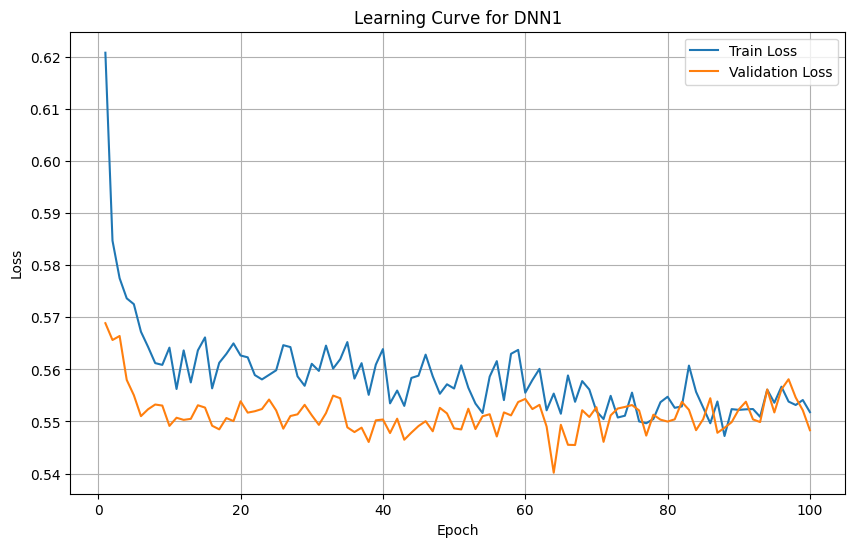

In [10]:
best_params=study.best_params
model = DNN_4(input_dim=X_train_tensor.shape[1],
              hidden_units1=best_params["hidden_units1"],
              hidden_units2=best_params["hidden_units2"],
              hidden_units3=best_params["hidden_units3"],
              hidden_units4=best_params["hidden_units4"],
              dropout1=best_params["dropout1"],
              dropout2=best_params["dropout2"],
              dropout3=best_params["dropout3"],
              dropout4=best_params["dropout4"]).to(device)
# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"],weight_decay=best_params["weight_decay"])
criterion = nn.BCELoss()

num_epochs=100
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val)
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN1')
plt.legend()
plt.grid()
plt.show()

Accuracy: 59.00%
Precision: 0.4591
Recall: 0.3481
F1 Score: 0.3960
Matthews Correlation Coefficient: 0.0965
Specificity: 0.7421


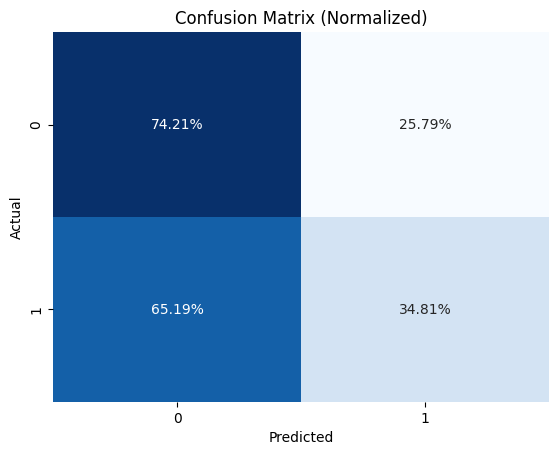

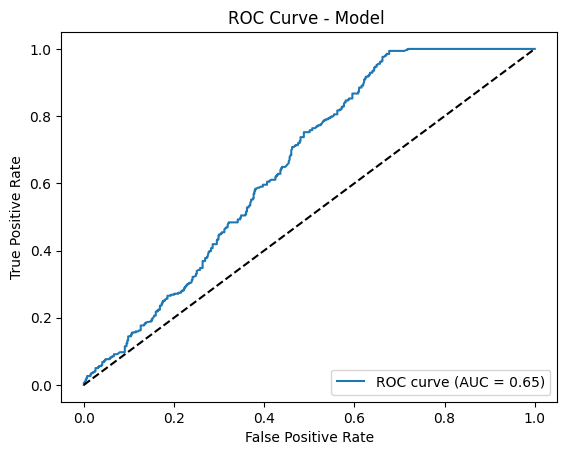

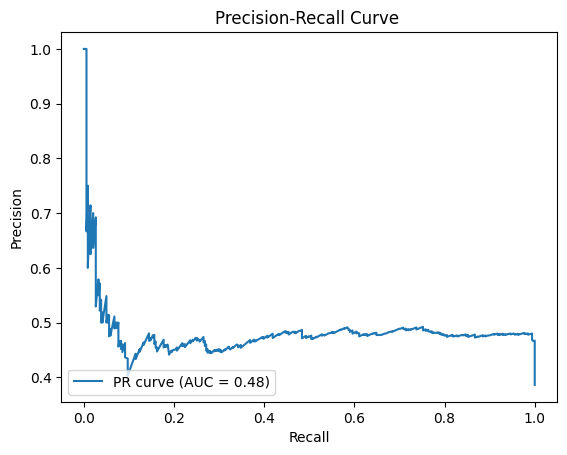

In [15]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >= 0.5).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [16]:
# モデルと構造を保存
torch.save(model, '../../saved_model/DNN_4.pth')
